## Relevant Githubs and website to have open while manipulating the data: 

**Json to CSV Converter**
https://github.com/Yelp/dataset-examples/blob/master/json_to_csv_converter.py

**Yelp Dataset Examples**
https://github.com/Yelp/dataset-examples
*This includes sentiment analysis files, might be worth looking into for whoever's conducting the sentiment analysis*

Tl;dr for using this notebook: run the first cell to download the necessary CSV, open the folder icon on the left side of the screen to make sure that the files are properly downloaded. **DO NOT RUN ANYTHING UNTIL THE BELOW CELL HAS FINISHED RUNNING**

 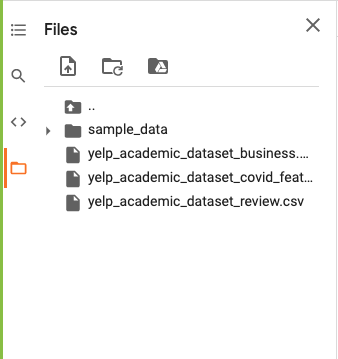


In [ ]:
# downloading the files so we don't need to mount drives; just give a minute / dozen seconds (when it takes long just be patient and wait!)

# covid_file_id = "1WWC8AwPufeJCN-J0tOR5BbjB1p_3hziK"
# !gdown https://drive.google.com/uc?id={covid_file_id}

business_file_id = "1injLQ5DTvZzXB-62buw-NNCPJqDPEToP"
!gdown https://drive.google.com/uc?id={business_file_id}

review_file_id = "1SpOhcM0Dm6lCD571y51e_vNlp_fFMw2k"
!gdown https://drive.google.com/uc?id={review_file_id}

# checkin_file_id = "1RTbuMPZFh2WFmnsFD63emShUQCasy5Ui"
# !gdown https://drive.google.com/uc?id={checkin_file_id}

# tips_file_id = "1FnkMQ2-QQDjWvK6iI3TUoEwKgC9YM8dL"
# !gdown https://drive.google.com/uc?id={tips_file_id}

Downloading...
From: https://drive.google.com/uc?id=1injLQ5DTvZzXB-62buw-NNCPJqDPEToP
To: /content/yelp_academic_dataset_business.csv
143MB [00:01, 104MB/s] 
Downloading...
From: https://drive.google.com/uc?id=1SpOhcM0Dm6lCD571y51e_vNlp_fFMw2k
To: /content/yelp_academic_dataset_review.csv
6.13GB [01:28, 69.6MB/s]


**RUN THE FOLLOWING CELLS FOR SET UP**

EDA

In [ ]:
import pandas as pd
import matplotlib as plt
import numpy as np

Explain Needed why we didn't use this dataset

Basic Info About Dataset

In [ ]:
business = pd.read_csv('/content/yelp_academic_dataset_business.csv', engine='python')
business.head()
# business.info()

,hours.Wednesday,attributes.RestaurantsDelivery,attributes.Open24Hours,attributes.DogsAllowed,attributes.CoatCheck,postal_code,attributes.Smoking,hours.Thursday,attributes.DietaryRestrictions,city,hours.Tuesday,attributes.RestaurantsGoodForGroups,attributes.BYOB,attributes.AgesAllowed,hours.Friday,stars,latitude,attributes.Alcohol,attributes.RestaurantsPriceRange2,attributes.RestaurantsTableService,attributes.HairSpecializesIn,business_id,attributes.RestaurantsCounterService,attributes.Corkage,attributes.GoodForKids,categories,name,attributes.BusinessAcceptsBitcoin,attributes.HappyHour,attributes.WheelchairAccessible,attributes.BusinessAcceptsCreditCards,attributes.BYOBCorkage,is_open,attributes.Ambience,longitude,hours.Monday,attributes.BestNights,hours.Saturday,review_count,attributes.ByAppointmentOnly,attributes.NoiseLevel,state,attributes.DriveThru,attributes.HasTV,attributes.WiFi,attributes.Music,hours,attributes.BusinessParking,address,attributes.RestaurantsAttire,hours.Sunday,attributes.GoodForMeal,attributes.GoodForDancing,attributes.Caters,attributes.AcceptsInsurance,attributes.RestaurantsReservations,attributes,attributes.RestaurantsTakeOut,attributes.BikeParking,attributes.OutdoorSeating
0,11:0-23:0,None,NaN,False,NaN,80302,NaN,11:0-23:0,NaN,Boulder,11:0-23:0,True,NaN,NaN,11:0-23:0,4.0,40.017544,'beer_and_wine',2,True,NaN,6iYb2HFDywm3zjuRg0shjw,NaN,NaN,NaN,"Gastropubs, Food, Beer Gardens, Restaurants, B...",Oskar Blues Taproom,False,True,True,True,NaN,1,"{'touristy': False, 'hipster': False, 'romanti...",-105.283348,11:0-23:0,NaN,11:0-23:0,86,NaN,u'average',CO,NaN,True,u'free',NaN,"{'Monday': '11:0-23:0', 'Tuesday': '11:0-23:0'...","{'garage': False, 'street': True, 'validated':...",921 Pearl St,'casual',11:0-23:0,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,True,NaN,False,"{'Alcohol': ""'beer_and_wine'"", 'HasTV': 'True'...",True,True,True
1,5:0-18:0,False,NaN,NaN,NaN,97218,NaN,5:0-18:0,NaN,Portland,5:0-17:0,False,NaN,NaN,5:0-18:0,4.0,45.588906,u'beer_and_wine',2,NaN,NaN,tCbdrRPZA0oiIYSmHG3J0w,NaN,NaN,True,"Salad, Soup, Sandwiches, Delis, Restaurants, C...",Flying Elephants at PDX,NaN,NaN,NaN,True,NaN,1,"{'romantic': False, 'intimate': False, 'touris...",-122.593331,5:0-18:0,NaN,5:0-18:0,126,False,u'average',OR,NaN,False,u'free',NaN,"{'Monday': '5:0-18:0', 'Tuesday': '5:0-17:0', ...","{'garage': True, 'street': False, 'validated':...",7000 NE Airport Way,u'casual',5:0-18:0,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,True,NaN,False,"{'GoodForMeal': ""{'dessert': False, 'latenight...",True,False,False
2,NaN,NaN,NaN,NaN,NaN,97214,NaN,11:0-18:0,NaN,Portland,NaN,NaN,NaN,NaN,11:0-18:0,4.5,45.511907,NaN,2,NaN,NaN,bvN78flM8NLprQ1a1y5dRg,NaN,NaN,NaN,"Antiques, Fashion, Used, Vintage & Consignment...",The Reclaimory,NaN,NaN,NaN,True,NaN,1,NaN,-122.613693,NaN,NaN,11:0-18:0,13,False,NaN,OR,NaN,NaN,NaN,NaN,"{'Sunday': '11:0-18:0', 'Friday': '11:0-18:0',...","{'garage': False, 'street': True, 'validated':...",4720 Hawthorne Ave,NaN,11:0-18:0,NaN,NaN,NaN,NaN,NaN,"{'BusinessAcceptsCreditCards': 'True', 'Restau...",NaN,False,NaN
3,NaN,NaN,NaN,NaN,NaN,32763,NaN,NaN,NaN,Orange City,NaN,NaN,NaN,NaN,NaN,3.0,28.914482,NaN,1,NaN,NaN,oaepsyvc0J17qwi8cfrOWg,NaN,NaN,True,"Beauty & Spas, Hair Salons",Great Clips,NaN,NaN,NaN,True,NaN,1,NaN,-81.295979,NaN,NaN,NaN,8,False,NaN,FL,NaN,NaN,NaN,NaN,NaN,NaN,2566 Enterprise Rd,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'BusinessAcceptsCreditCards': 'True', 'Restau...",NaN,NaN,NaN
4,16:0-19:0,NaN,NaN,NaN,NaN,30316,NaN,16:0-19:0,NaN,Atlanta,16:0-19:0,NaN,NaN,NaN,16:0-19:0,4.0,33.747027,NaN,NaN,NaN,NaN,PE9uqAjdw0E4-8mjGl3wVA,NaN,NaN,False,"Gyms, Active Life, Interval Training Gyms, Fit...",Crossfit Terminus,NaN,NaN,NaN,True,NaN,1,NaN,-84.353424,16:0-19:0,NaN,9:0-11:0,14,NaN,NaN,GA,NaN,NaN,NaN,NaN,"{'Monday': '16:0-19:0', 'Tuesday': '16:0-19:0'...","{'garage': False, 'street': False, 'validated'...",1046 Memorial Dr SE,NaN,NaN,NaN,NaN,NaN,NaN,NaN,"{'BusinessAcceptsCreditCards': 'True', 'GoodFo.

In [ ]:
business.shape

(160585, 60)

In [ ]:
# This information reveals that many business categories are just rearrangements of the same words, so we extract the keyword "Restaurants" and filter our data using that

business['categories'].value_counts()

Beauty & Spas, Hair Salons                                                                                                     757
Restaurants, Pizza                                                                                                             748
Hair Salons, Beauty & Spas                                                                                                     742
Pizza, Restaurants                                                                                                             740
Beauty & Spas, Nail Salons                                                                                                     734
                                                                                                                              ... 
Landmarks & Historical Buildings, Local Services, Local Flavor, Funeral Services & Cemeteries, Public Services & Government      1
Mediterranean, Sandwiches, American (Traditional), Chicken Wings, Restaurants      

In [ ]:
# Add new column "restaurant" as an indicator of whether the business is a restaurant

restaurant = []
for i in range(len(business)):
  biz = business['categories'][i]
  if isinstance(biz, str) and biz.find('Restaurants') > 0:
    restaurant.append(1)
  else:
    restaurant.append(0)
business['Restaurant'] = restaurant

In [ ]:
# Filter out businesses that are not restaurants - they're not our concern in this project

restaurant = business.loc[business['Restaurant']==1]

In [ ]:
# Filter out businesses that are not restaurants - they're not our concern in this project
# Also drop "hours" due to redundancy and drop "name" and "address" because they shouldn't matter

restaurant = restaurant.drop(['hours', 'name', 'address', 'Restaurant', 'attributes.HairSpecializesIn', 'attributes.AcceptsInsurance'], axis=1).set_index('business_id').sort_index()

Text(0.5, 1.0, 'Histogram of Restaurants Open or Closed')

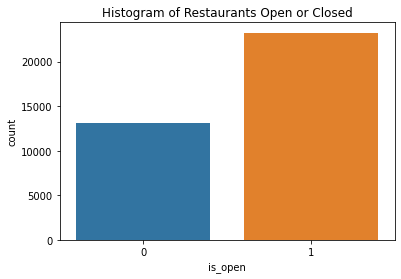

In [ ]:
#checking is_open column
#Roughly 40,000 that are closed and 120,000 that are open
import seaborn as sns
sns.countplot(x = "is_open", data = restaurant).set_title("Histogram of Restaurants Open or Closed")

In [ ]:
percentage_open = len(restaurant.loc[restaurant['is_open']==1])/len(restaurant)
percentage_open

0.6394606494221243

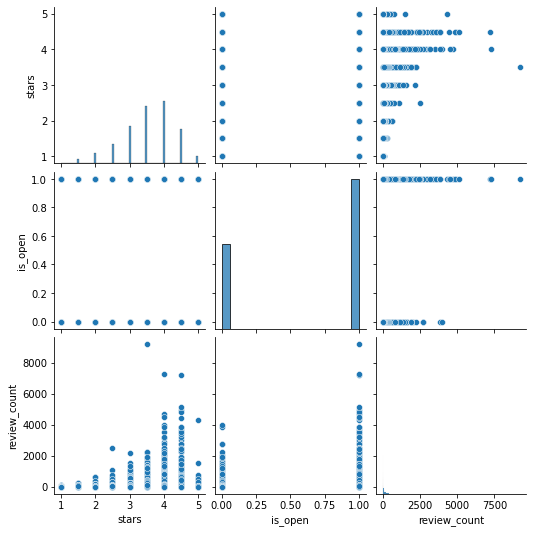

In [ ]:
sns.pairplot(restaurant, vars=['stars', 'is_open', 'review_count'], markers=["o", "s"])

In [ ]:
a = business.isna().sum()
a.sort_values()

Restaurant                                   0
business_id                                  0
name                                         0
is_open                                      0
city                                         0
                                         ...  
attributes.HairSpecializesIn            159392
attributes.AgesAllowed                  160488
attributes.DietaryRestrictions          160517
attributes.Open24Hours                  160543
attributes.RestaurantsCounterService    160545
Length: 61, dtype: int64

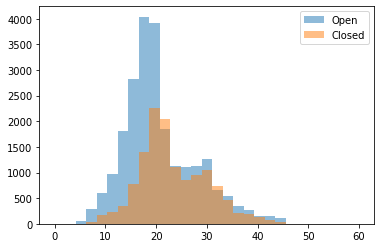

In [ ]:
# Get counts of missing values for each business
## na_counts is a list of numbers that represent the #missing values for each restaurant

restaurant["na_counts"] = restaurant.isnull().sum(axis=1)
# Overlaying histograms of na_count for open and close businesses 

from matplotlib import pyplot as plt

open_na = restaurant.loc[restaurant["is_open"] == 1]["na_counts"]
closed_na = restaurant.loc[restaurant["is_open"] == 0]["na_counts"]

bins = np.linspace(0, 60, 30)
plt.hist(open_na.values, bins, alpha = 0.5, label = "Open")
plt.hist(closed_na.values, bins, alpha = 0.5, label = "Closed")
plt.legend(loc="upper right")
plt.show()

In [ ]:
# TURN THE HOURS COLUMNS INTO HOURS PER WEEK
from datetime import datetime 
import math

def hoursToFloat(hours):
  # returns number of minutes the store is open
  if hours != hours:
    return -1
  if hours == '0:0-0:0': # 08:00-17:00
    return float(24)

  opening = 0
  closing = 0
  [time_open, time_close] = hours.split('-')
  
  time_open += ':00'
  time_close += ':00'
  
  time_open = datetime.strptime(time_open, "%X")
  time_close = datetime.strptime(time_close, "%X")

  delta = time_close - time_open
  return delta.seconds/3600

hours_day = ['hours.Sunday', 'hours.Monday', 'hours.Tuesday', 'hours.Wednesday', 'hours.Thursday', 'hours.Friday', 'hours.Saturday']
totalhours_day = ['totalhours.Sunday', 'totalhours.Monday', 'totalhours.Tuesday', 'totalhours.Wednesday', 
              'totalhours.Thursday', 'totalhours.Friday','totalhours.Saturday']


for i in range(7):
  restaurant[totalhours_day[i]] = restaurant[hours_day[i]].apply(hoursToFloat)

In [ ]:
restaurant = restaurant.reindex(sorted(restaurant.columns), axis=1)
restaurant.head()

,attributes,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience,attributes.BYOB,attributes.BYOBCorkage,attributes.BestNights,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,attributes.BusinessAcceptsCreditCards,attributes.BusinessParking,attributes.ByAppointmentOnly,attributes.Caters,attributes.CoatCheck,attributes.Corkage,attributes.DietaryRestrictions,attributes.DogsAllowed,attributes.DriveThru,attributes.GoodForDancing,attributes.GoodForKids,attributes.GoodForMeal,attributes.HappyHour,attributes.HasTV,attributes.Music,attributes.NoiseLevel,attributes.Open24Hours,attributes.OutdoorSeating,attributes.RestaurantsAttire,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.Smoking,attributes.WheelchairAccessible,attributes.WiFi,categories,city,hours.Friday,hours.Monday,hours.Saturday,hours.Sunday,hours.Thursday,hours.Tuesday,hours.Wednesday,is_open,latitude,longitude,na_counts,postal_code,review_count,stars,state,totalhours.Friday,totalhours.Monday,totalhours.Saturday,totalhours.Sunday,totalhours.Thursday,totalhours.Tuesday,totalhours.Wednesday
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--164t1nclzzmca7eDiJMw,"{'Alcohol': ""u'full_bar'"", 'Caters': 'True', '...",NaN,u'full_bar',"{'romantic': False, 'intimate': False, 'touris...",NaN,NaN,NaN,NaN,NaN,True,"{'garage': False, 'street': True, 'validated':...",NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,False,NaN,u'average',NaN,True,u'casual',NaN,True,True,1,False,NaN,True,NaN,NaN,u'free',"Food, Ethnic Food, Nightlife, Restaurants, Div...",Austin,11:30-2:0,18:0-0:0,19:0-2:0,19:0-1:0,11:30-2:0,11:30-0:0,11:30-0:0,0,30.264896,-97.731028,21,78702,137,4.0,TX,14.5,6.0,7.0,6.0,14.5,12.5,12.5
--6COJIAjkQwSUZci_4PJQ,"{'Alcohol': ""u'none'"", 'HasTV': 'False', 'Nois...",NaN,u'none',"{'romantic': False, 'intimate': False, 'touris...",NaN,NaN,NaN,True,False,True,"{'garage': False, 'street': True, 'validated':...",NaN,True,NaN,NaN,NaN,False,NaN,NaN,True,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,False,NaN,u'quiet',NaN,False,u'casual',NaN,False,True,2,True,True,True,NaN,True,u'free',"Breakfast & Brunch, Bakeries, Tea Rooms, Coffe...",Portland,9:0-16:0,0:0-0:0,9:0-16:0,9:0-16:0,9:0-16:0,9:0-16:0,9:0-16:0,0,45.467868,-122.714524,15,97219,99,4.0,OR,7.0,24.0,7.0,7.0,7.0,7.0,7.0
--Q3mAcX9t63f7Xcbn7LVA,"{'Ambience': ""{'touristy': False, 'hipster': F...",NaN,NaN,"{'touristy': False, 'hipster': False, 'romanti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,"American (Traditional), Restaurants, Gastropubs",Columbus,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,40.145557,-82.977284,39,43240,107,4.5,OH,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0
--UNNdnHRhsyFUbDgumdtQ,"{'Alcohol': ""'beer_and_wine'"", 'HasTV': 'False...",NaN,'beer_and_wine',"{'touristy': False, 'hipster': False, 'romanti...",NaN,'yes_corkage',NaN,True,False,True,"{'garage': False, 'street': True, 'validated':...",NaN,False,NaN,True,NaN,False,NaN,NaN,False,"{'dessert': False, 'latenight': False, 'lunch'...",False,False,NaN,u'average',NaN,None,'casual',NaN,None,False,3,True,True,True,NaN,True,u'free',"French, Restaurants, American (New)",Portland,17:0-22:0,0:0-0:0,17:0-22:0,NaN,17:0-22:0,17:0-22:0,17:0-22:0,1,45.522796,-122.657872,13,97214,1236,4.5,OR,5.0,24.0,5.0,-1.0,5.0,5.0,5.0
--_nBudPOb1lNRgKfjLtrw,"{'BusinessParking': ""{'garage': False, 'street...",NaN,u'full_bar',"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,NaN,True,"{'garage': False, 'street': False, 'validated'...",NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,True,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,True,NaN,'average',NaN,False,u'casual',NaN,False,True,2,False,True,True,NaN,NaN,'no',"Mexican, Gastropubs, Restaurants",Columb

In [ ]:
# So we drop all hours.DAY columns and replace them with a numerical column that counts the total hours that a restaurant is open each weekday

restaurant = restaurant.drop(['hours.Monday', 'hours.Tuesday', 'hours.Wednesday', 'hours.Thursday', 'hours.Friday', 'hours.Saturday', 'hours.Sunday'], axis = 1)

In [ ]:
# Drop attributes column due to information repetition

restaurant = restaurant.drop(['attributes'], axis = 1)

In [ ]:
restaurant['attributes.GoodForMeal'].value_counts()

{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': False, 'brunch': False, 'breakfast': False}    5656
{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': True, 'brunch': False, 'breakfast': False}      3954
{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': False, 'brunch': False, 'breakfast': False}     1980
{'dessert': False, 'latenight': False, 'lunch': False, 'dinner': True, 'brunch': False, 'breakfast': False}     1376
{'dessert': False, 'latenight': False, 'lunch': True, 'dinner': False, 'brunch': True, 'breakfast': True}        479
                                                                                                                ... 
{'dessert': True, 'latenight': True, 'lunch': True, 'dinner': True, 'brunch': None, 'breakfast': True}             1
{'dessert': False, 'latenight': True, 'lunch': False, 'dinner': True, 'brunch': False, 'breakfast': True}          1
{'dessert': False, 'latenight': None, 'lunch': True, 'dinner': T

In [ ]:
dessert = [0]*len(restaurant)
latenight = [0]*len(restaurant)
lunch = [0]*len(restaurant)
dinner = [0]*len(restaurant)
brunch = [0]*len(restaurant)
breakfast = [0]*len(restaurant)
goodformeal = restaurant['attributes.GoodForMeal'].values
for i in range(len(goodformeal)):
  if goodformeal[i]==goodformeal[i] and "'dessert': True" in goodformeal[i]:
    dessert[i] = 1
  if goodformeal[i]==goodformeal[i] and "'latenight': True" in goodformeal[i]:
    latenight[i] = 1
  if goodformeal[i]==goodformeal[i] and "'lunch': True" in goodformeal[i]:
    lunch[i] = 1
  if goodformeal[i]==goodformeal[i] and "'dinner': True" in goodformeal[i]:
    dinner[i] = 1
  if goodformeal[i]==goodformeal[i] and "'brunch': True" in goodformeal[i]:
    brunch[i] = 1
  if goodformeal[i]==goodformeal[i] and "'breakfast': True" in goodformeal[i]:
    breakfast[i] = 1
  else:
    continue

In [ ]:
goodformeal_columns = ['dessert', 'latenight_food', 'lunch', 'dinner', 'brunch', 'breakfast']
goodformeal_lists = [dessert, latenight, lunch, dinner, brunch, breakfast]
for i in range(6):
  restaurant[goodformeal_columns[i]] = goodformeal_lists[i]

In [ ]:
restaurant['attributes.Ambience'].value_counts()

{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': True}     3725
{'touristy': False, 'hipster': False, 'romantic': False, 'divey': False, 'intimate': False, 'trendy': False, 'upscale': False, 'classy': False, 'casual': False}    3723
{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': True}     3703
{'romantic': False, 'intimate': False, 'classy': False, 'hipster': False, 'divey': False, 'touristy': False, 'trendy': False, 'upscale': False, 'casual': False}    2860
{'romantic': False, 'intimate': False, 'touristy': False, 'hipster': False, 'divey': False, 'classy': False, 'trendy': False, 'upscale': False, 'casual': False}    1802
                                                                                                                                                           

In [ ]:
restaurant['attributes.BusinessParking'].value_counts()

{'garage': False, 'street': False, 'validated': False, 'lot': True, 'valet': False}     10939
{'garage': False, 'street': True, 'validated': False, 'lot': False, 'valet': False}      8186
{'garage': False, 'street': False, 'validated': False, 'lot': False, 'valet': False}     6044
{'garage': False, 'street': True, 'validated': False, 'lot': True, 'valet': False}       2565
{'garage': True, 'street': True, 'validated': False, 'lot': False, 'valet': False}        707
                                                                                        ...  
{'garage': True, 'street': False, 'validated': True, 'lot': None, 'valet': False}           1
{'garage': False, 'street': None, 'validated': False, 'lot': None, 'valet': True}           1
{'garage': None, 'street': True, 'validated': True, 'lot': None, 'valet': False}            1
{'garage': True, 'street': None, 'validated': None, 'lot': True, 'valet': False}            1
{'garage': None, 'street': None, 'validated': True, 'lot': F

In [ ]:
# Decompose attributes.Ambience column

romantic = [0]*len(restaurant)
intimate = [0]*len(restaurant)
touristy = [0]*len(restaurant)
hipster = [0]*len(restaurant)
divey = [0]*len(restaurant)
classy = [0]*len(restaurant)
trendy = [0]*len(restaurant)
upscale = [0]*len(restaurant)
casual = [0]*len(restaurant)
ambience = restaurant['attributes.Ambience'].values
for i in range(len(ambience)):
  if ambience[i] == ambience[i] and "'romantic': True" in ambience[i]:
    romantic[i] = 1
  if ambience[i] == ambience[i] and "'intimate': True" in ambience[i]:
    intimate[i] = 1
  if ambience[i] == ambience[i] and "'touristy': True" in ambience[i]:
    touristy[i] = 1
  if ambience[i] == ambience[i] and "'hipster': True" in ambience[i]:
    hipster[i] = 1
  if ambience[i] == ambience[i] and "'divey': True" in ambience[i]:
    divey[i] = 1
  if ambience[i] == ambience[i] and "'classy': True" in ambience[i]:
    classy[i] = 1
  if ambience[i] == ambience[i] and "'trendy': True" in ambience[i]:
    trendy[i] = 1
  if ambience[i] == ambience[i] and "'upscale': True" in ambience[i]:
    upscale[i] = 1
  if ambience[i] == ambience[i] and "'casual': True" in ambience[i]:
    casual[i] = 1
  else:
    continue

In [ ]:
ambience_columns = ['romantic', 'intimate', 'touristy', 'hipster', 'divey', 'classy', 'trendy', 'upscale', 'casual']
ambience_lists = [romantic, intimate, touristy, hipster, divey, classy, trendy, upscale, casual]
for i in range(9):
  restaurant[ambience_columns[i]] = ambience_lists[i]

In [ ]:
# Similarly, decompose parking attribute

garage = [0]*len(restaurant)
street = [0]*len(restaurant)
validated = [0]*len(restaurant)
lot = [0]*len(restaurant)
valet = [0]*len(restaurant)
parking = restaurant['attributes.BusinessParking'].values
for i in range(len(parking)):
  if parking[i] == parking[i] and "'garage': True" in parking[i]:
    garage[i] = 1
  if parking[i] == parking[i] and "'street': True" in parking[i]:
    street[i] = 1
  if parking[i] == parking[i] and "'validated': True" in parking[i]:
    validated[i] = 1
  if parking[i] == parking[i] and "'lot': True" in parking[i]:
    lot[i] = 1
  if parking[i] == parking[i] and "'valet': True" in parking[i]:
    valet[i] = 1
  else:
    continue

In [ ]:
parking_columns = ['garage parking', 'street parking', 'validated parking', 'parking lot', 'valet parking']
parking_lists = [garage, street, validated, lot, valet]
for i in range(5):
  restaurant[parking_columns[i]] = parking_lists[i]

In [ ]:
restaurant.head()

,attributes.AgesAllowed,attributes.Alcohol,attributes.Ambience,attributes.BYOB,attributes.BYOBCorkage,attributes.BestNights,attributes.BikeParking,attributes.BusinessAcceptsBitcoin,attributes.BusinessAcceptsCreditCards,attributes.BusinessParking,attributes.ByAppointmentOnly,attributes.Caters,attributes.CoatCheck,attributes.Corkage,attributes.DietaryRestrictions,attributes.DogsAllowed,attributes.DriveThru,attributes.GoodForDancing,attributes.GoodForKids,attributes.GoodForMeal,attributes.HappyHour,attributes.HasTV,attributes.Music,attributes.NoiseLevel,attributes.Open24Hours,attributes.OutdoorSeating,attributes.RestaurantsAttire,attributes.RestaurantsCounterService,attributes.RestaurantsDelivery,attributes.RestaurantsGoodForGroups,attributes.RestaurantsPriceRange2,attributes.RestaurantsReservations,attributes.RestaurantsTableService,attributes.RestaurantsTakeOut,attributes.Smoking,attributes.WheelchairAccessible,attributes.WiFi,categories,city,is_open,latitude,longitude,na_counts,postal_code,review_count,stars,state,totalhours.Friday,totalhours.Monday,totalhours.Saturday,totalhours.Sunday,totalhours.Thursday,totalhours.Tuesday,totalhours.Wednesday,romantic,intimate,touristy,hipster,divey,classy,trendy,upscale,casual,garage parking,street parking,validated parking,parking lot,valet parking,dessert,latenight_food,lunch,dinner,brunch,breakfast
business_id,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
--164t1nclzzmca7eDiJMw,NaN,u'full_bar',"{'romantic': False, 'intimate': False, 'touris...",NaN,NaN,NaN,NaN,NaN,True,"{'garage': False, 'street': True, 'validated':...",NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,False,NaN,u'average',NaN,True,u'casual',NaN,True,True,1,False,NaN,True,NaN,NaN,u'free',"Food, Ethnic Food, Nightlife, Restaurants, Div...",Austin,0,30.264896,-97.731028,21,78702,137,4.0,TX,14.5,6.0,7.0,6.0,14.5,12.5,12.5,0,0,0,1,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0
--6COJIAjkQwSUZci_4PJQ,NaN,u'none',"{'romantic': False, 'intimate': False, 'touris...",NaN,NaN,NaN,True,False,True,"{'garage': False, 'street': True, 'validated':...",NaN,True,NaN,NaN,NaN,False,NaN,NaN,True,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,False,NaN,u'quiet',NaN,False,u'casual',NaN,False,True,2,True,True,True,NaN,True,u'free',"Breakfast & Brunch, Bakeries, Tea Rooms, Coffe...",Portland,0,45.467868,-122.714524,15,97219,99,4.0,OR,7.0,24.0,7.0,7.0,7.0,7.0,7.0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,0,1,1
--Q3mAcX9t63f7Xcbn7LVA,NaN,NaN,"{'touristy': False, 'hipster': False, 'romanti...",NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,NaN,NaN,NaN,True,NaN,NaN,True,NaN,NaN,NaN,NaN,True,NaN,NaN,NaN,"American (Traditional), Restaurants, Gastropubs",Columbus,1,40.145557,-82.977284,39,43240,107,4.5,OH,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,-1.0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0
--UNNdnHRhsyFUbDgumdtQ,NaN,'beer_and_wine',"{'touristy': False, 'hipster': False, 'romanti...",NaN,'yes_corkage',NaN,True,False,True,"{'garage': False, 'street': True, 'validated':...",NaN,False,NaN,True,NaN,False,NaN,NaN,False,"{'dessert': False, 'latenight': False, 'lunch'...",False,False,NaN,u'average',NaN,None,'casual',NaN,None,False,3,True,True,True,NaN,True,u'free',"French, Restaurants, American (New)",Portland,1,45.522796,-122.657872,13,97214,1236,4.5,OR,5.0,24.0,5.0,-1.0,5.0,5.0,5.0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,0,1,0,0
--_nBudPOb1lNRgKfjLtrw,NaN,u'full_bar',"{'romantic': False, 'intimate': False, 'classy...",NaN,NaN,NaN,True,NaN,True,"{'garage': False, 'street': False, 'validated'...",NaN,False,NaN,NaN,NaN,NaN,NaN,NaN,True,"{'dessert': False, 'latenight': False, 'lunch'...",NaN,True,NaN,'average',NaN,False,u'casual',NaN,False,True,2,False,True,True,NaN,NaN,'no',"Mexican, Gastropubs, Restaurants",Columbus,0,40.117275,-83.068481,19,43235,8,4.0,OH,6.0,-1.0,6.0,5.0,6.0,6.0,6.0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [ ]:
from google.colab import files

restaurant.to_csv('restaurant.csv')
files.download('restaurant.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>